In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

## Experiments with various learning rates
1. Cyclical learning rate
   ref : https://www.pyimagesearch.com/2019/07/29/cyclical-learning-rates-with-keras-and-deep-learning/
 


In [2]:
import os
import shutil
import time
import datetime
import random

import numpy as np

from tensorflow.keras import layers,models,utils,optimizers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import TensorBoard,EarlyStopping,LearningRateScheduler
from util.custom_callbacks import SkipLoggerCallback,StepDecayHistoryCallback
from util.custom_callbacks import step_decay
from util.clr_callback import CyclicLR 

import matplotlib.pyplot as plt

In [3]:
DATA_DIR = 'data/caps_and_shoes_squared/'
IMAGE_SIZE = (28,28)
CLASS_LIST = ['cap','shoes']
BATCH_SIZE = 32

train_path = DATA_DIR + 'train'
validation_path = DATA_DIR + 'val'
test_path = DATA_DIR + 'test'

SOURCE_DATA_DIR = 'data/caps_and_shoes_squared_2/'
TEST_DATA_DIR = 'data/out_of_set_tests/'

In [4]:
def create_test_set(seed=random.randint(1,10000)):

    dirpath = os.path.join(TEST_DATA_DIR, 'temp_test')
    if os.path.exists(dirpath) and os.path.isdir(dirpath):
        shutil.rmtree(dirpath)
        
    os.makedirs(dirpath, exist_ok=True)
    
    for class_name in CLASS_LIST:
        src_dir = os.path.join(SOURCE_DATA_DIR, class_name)
        dest_dir = os.path.join(dirpath, class_name)
        os.makedirs(dest_dir, exist_ok=True)
        
        src_files = (os.listdir(src_dir))
        random.seed(seed)
        choices = random.sample(src_files, 25)
        for file_name in choices:
            shutil.copy(os.path.join(src_dir, file_name), dest_dir)
            
def get_oos_test_accuracy(model=None):
    
    out_test_accuracy_log = []
    
    for iter_count in range(25):
    
        seed = random.randint(1,10000)
        create_test_set(seed)

        test_img_generator = ImageDataGenerator(rescale = 1./255)
        test_batches = test_img_generator.flow_from_directory(os.path.join(TEST_DATA_DIR, 'temp_test'),
                                                              target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                              class_mode = 'categorical', batch_size=32)
        test_loss, test_accuracy = model.evaluate_generator(test_batches, workers=4, verbose=0) 
        out_test_accuracy_log.append(test_accuracy)
    
    return (np.mean(out_test_accuracy_log),np.std(out_test_accuracy_log))

In [5]:
test_img_generator = ImageDataGenerator( rescale = 1./255)
train_validation_img_generator = ImageDataGenerator(validation_split=0.2, rescale = 1./255, rotation_range = 10, width_shift_range = 0.1, height_shift_range=0.1, zoom_range = 0.1, 
                                   horizontal_flip=True, fill_mode='nearest')

train_batches = train_validation_img_generator.flow_from_directory(train_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                  class_mode = 'categorical', batch_size=BATCH_SIZE, subset='training')

validation_batches = train_validation_img_generator.flow_from_directory(train_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                  class_mode = 'categorical', batch_size=BATCH_SIZE, subset='validation')

test_batches = test_img_generator.flow_from_directory(test_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                  class_mode = 'categorical',batch_size=1, shuffle=False)

Found 1832 images belonging to 2 classes.
Found 457 images belonging to 2 classes.
Found 326 images belonging to 2 classes.


In [6]:
def define_model_architecture_64_32_16():
    model = models.Sequential()
    model.add(Flatten(input_shape = (28,28,1)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return model

### Cyclical Learning rate

In [20]:
MIN_LR = 1e-5
MAX_LR = 1e-2
BATCH_SIZE = 32
STEP_SIZE = 8
CLR_METHOD = "triangular"
EPOCHS = 600
NUM_CLR_CYCLES = EPOCHS / STEP_SIZE / 2

In [21]:
sgd_optimizer = optimizers.SGD(lr=MIN_LR, momentum=0.9)
model = define_model_architecture_64_32_16()
model.compile(loss="binary_crossentropy", optimizer=sgd_optimizer, metrics=["accuracy"])

In [22]:
!rm -rf ./logs/
skipLogger_callback = SkipLoggerCallback(n=25)

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
clr_callback = CyclicLR(mode=CLR_METHOD, base_lr=MIN_LR, max_lr=MAX_LR,step_size= STEP_SIZE * (train_batches.samples/BATCH_SIZE))

callback_list = [tb_callback, skipLogger_callback,clr_callback]

In [23]:
start = time.time()
history = model.fit_generator(generator = train_batches, steps_per_epoch=train_batches.samples/BATCH_SIZE, 
                              validation_data = validation_batches, validation_steps = validation_batches.samples/BATCH_SIZE, 
                              epochs=EPOCHS, verbose=0, workers=4, callbacks = callback_list)

print('time taken : %.4f' % (time.time() - start))
oos_test_loss, oos_test_accuracy = get_oos_test_accuracy(model)
print('OOS Test loss: %.4f OOS std dev: %.4f' % (oos_test_loss, oos_test_accuracy))    
test_loss, test_accuracy = model.evaluate_generator(test_batches, workers=4, verbose=0) 
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))    

epoch =    0    loss = 0.690733    accuracy = 0.53    val_loss = 0.706540    val_accuracy = 0.60
epoch =   25    loss = 0.556051    accuracy = 0.72    val_loss = 0.578550    val_accuracy = 0.69
epoch =   50    loss = 0.483070    accuracy = 0.78    val_loss = 0.550252    val_accuracy = 0.75
epoch =   75    loss = 0.461535    accuracy = 0.79    val_loss = 0.577079    val_accuracy = 0.74
epoch =  100    loss = 0.478189    accuracy = 0.77    val_loss = 0.533051    val_accuracy = 0.77
epoch =  125    loss = 0.419737    accuracy = 0.81    val_loss = 0.473982    val_accuracy = 0.81
epoch =  150    loss = 0.460603    accuracy = 0.78    val_loss = 0.466167    val_accuracy = 0.81
epoch =  175    loss = 0.396713    accuracy = 0.81    val_loss = 0.538571    val_accuracy = 0.77
epoch =  200    loss = 0.425415    accuracy = 0.80    val_loss = 0.460286    val_accuracy = 0.80
epoch =  225    loss = 0.378134    accuracy = 0.83    val_loss = 0.447170    val_accuracy = 0.80
epoch =  250    loss = 0.36949

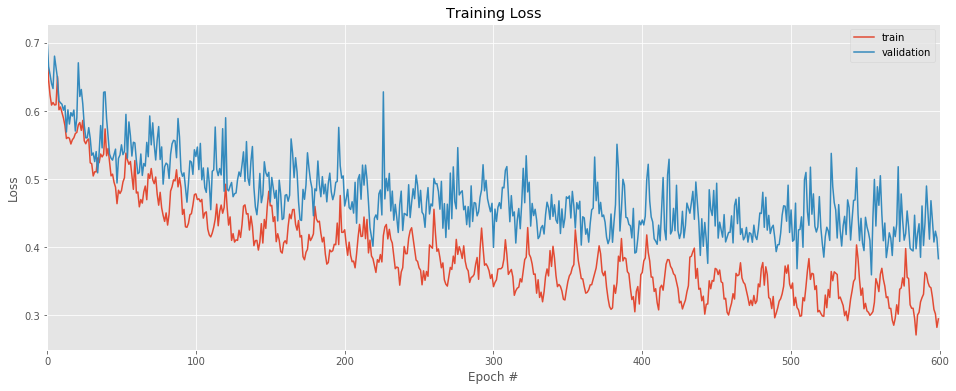

In [24]:
plt.style.use("ggplot")
plt.figure(figsize=(16, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.xlim(0, EPOCHS)
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.show()

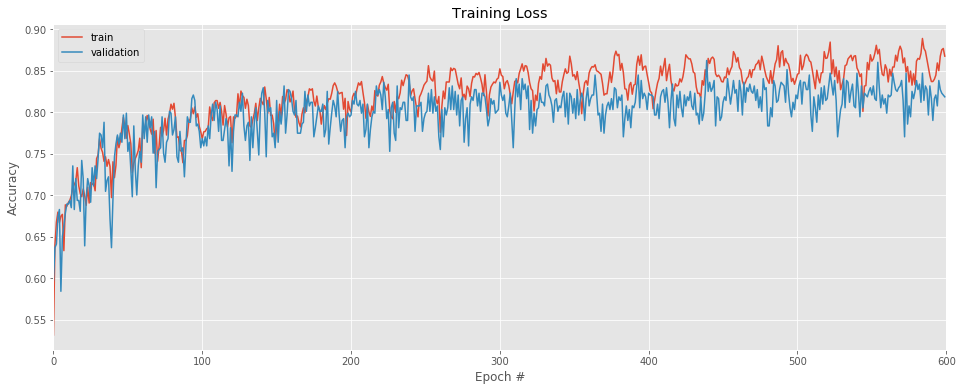

In [25]:
plt.style.use("ggplot")
plt.figure(figsize=(16, 6))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.xlim(0, EPOCHS)
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.show()

Text(0, 0.5, 'Learning Rate')

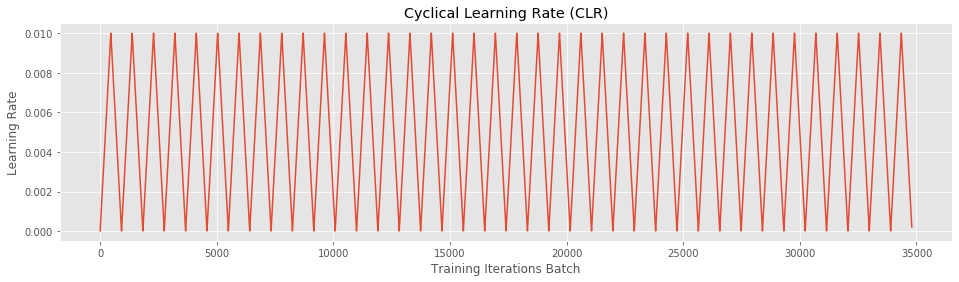

In [29]:
N = np.arange(0, len(clr_callback.history["lr"]))
plt.figure(figsize=(16, 4))
plt.plot(N, clr_callback.history["lr"])
plt.title("Cyclical Learning Rate (CLR)")
plt.xlabel("Training Iterations Batch")
plt.ylabel("Learning Rate")

In [17]:
MIN_LR = 6e-4
MAX_LR = 6.6e-3
BATCH_SIZE = 32
STEP_SIZE = 8
CLR_METHOD = "triangular2"
EPOCHS = 640
NUM_CLR_CYCLES = EPOCHS / STEP_SIZE / 2
print(NUM_CLR_CYCLES)
print(STEP_SIZE * (train_batches.samples/BATCH_SIZE))
57*640

40.0
458.0


36480

In [15]:
sgd_optimizer = optimizers.SGD(lr=MIN_LR, momentum=0.9)
model = define_model_architecture_64_32_16()
model.compile(loss="binary_crossentropy", optimizer=sgd_optimizer, metrics=["accuracy"])

In [16]:
!rm -rf ./logs/
skipLogger_callback = SkipLoggerCallback(n=25)

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
clr_callback = CyclicLR(mode=CLR_METHOD, base_lr=MIN_LR, max_lr=MAX_LR,step_size= STEP_SIZE * (train_batches.samples/BATCH_SIZE))

callback_list = [tb_callback, skipLogger_callback,clr_callback]

In [10]:
start = time.time()
history = model.fit_generator(generator = train_batches, steps_per_epoch=train_batches.samples/BATCH_SIZE, 
                              validation_data = validation_batches, validation_steps = validation_batches.samples/BATCH_SIZE, 
                              epochs=EPOCHS, verbose=0, workers=4, callbacks = callback_list)

print('time taken : %.4f' % (time.time() - start))
oos_test_loss, oos_test_accuracy = get_oos_test_accuracy(model)
print('OOS Test loss: %.4f OOS std dev: %.4f' % (oos_test_loss, oos_test_accuracy))    
test_loss, test_accuracy = model.evaluate_generator(test_batches, workers=4, verbose=0) 
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))    

W0908 16:45:10.055535 140590296663872 deprecation.py:323] From /home/algolaptop8/anaconda3/envs/tf2-env/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


epoch =    0    loss = 0.663044    accuracy = 0.62    val_loss = 0.708283    val_accuracy = 0.58
epoch =   25    loss = 0.529412    accuracy = 0.73    val_loss = 0.554055    val_accuracy = 0.77
epoch =   50    loss = 0.453758    accuracy = 0.80    val_loss = 0.519947    val_accuracy = 0.77
epoch =   75    loss = 0.442322    accuracy = 0.81    val_loss = 0.475664    val_accuracy = 0.80
epoch =  100    loss = 0.425519    accuracy = 0.81    val_loss = 0.479841    val_accuracy = 0.81
epoch =  125    loss = 0.393510    accuracy = 0.83    val_loss = 0.464785    val_accuracy = 0.78
epoch =  150    loss = 0.406284    accuracy = 0.81    val_loss = 0.469913    val_accuracy = 0.80
epoch =  175    loss = 0.386202    accuracy = 0.83    val_loss = 0.426359    val_accuracy = 0.81
epoch =  200    loss = 0.373643    accuracy = 0.84    val_loss = 0.463258    val_accuracy = 0.80
epoch =  225    loss = 0.357591    accuracy = 0.84    val_loss = 0.422921    val_accuracy = 0.83
epoch =  250    loss = 0.36789

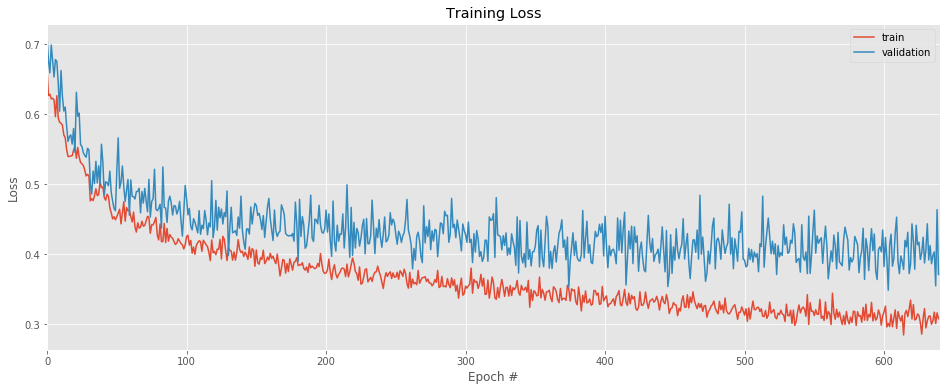

In [11]:
plt.style.use("ggplot")
plt.figure(figsize=(16, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.xlim(0, EPOCHS)
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.show()

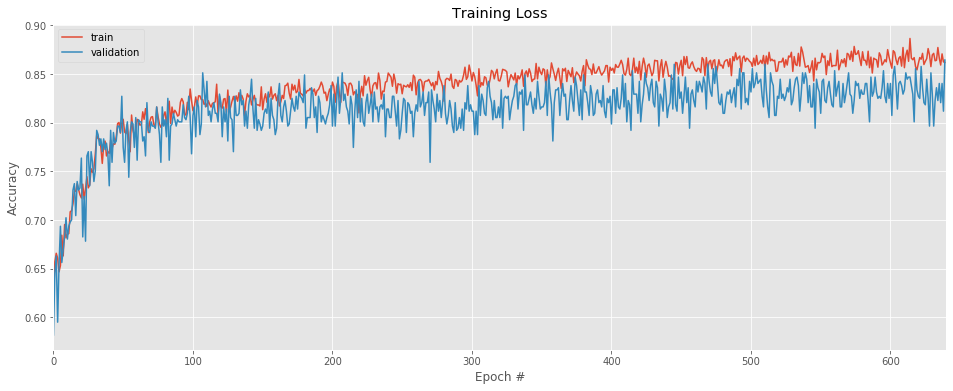

In [12]:
plt.style.use("ggplot")
plt.figure(figsize=(16, 6))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.xlim(0, EPOCHS)
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.show()

Text(0, 0.5, 'Learning Rate')

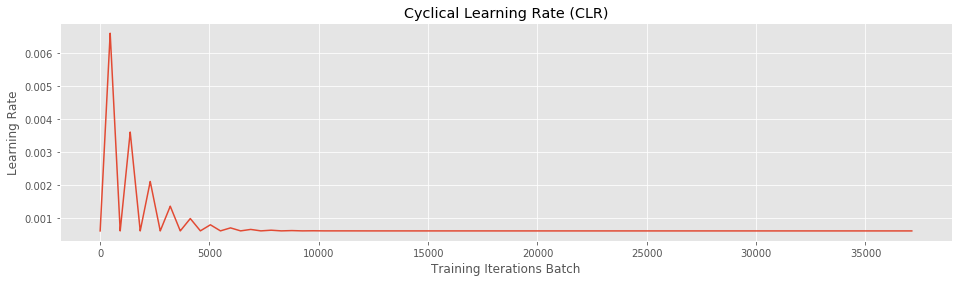

In [13]:
N = np.arange(0, len(clr_callback.history["lr"]))
plt.figure(figsize=(16, 4))
plt.plot(N, clr_callback.history["lr"])
plt.title("Cyclical Learning Rate (CLR)")
plt.xlabel("Training Iterations Batch")
plt.ylabel("Learning Rate")

### Learning rate schedule with Adam

In [19]:
MIN_LR = 6e-4
MAX_LR = 6.6e-3
BATCH_SIZE = 32
STEP_SIZE = 8
CLR_METHOD = "triangular2"
EPOCHS = 640
NUM_CLR_CYCLES = EPOCHS / STEP_SIZE / 2

In [21]:
adam_optimizer = optimizers.Adam(lr=MIN_LR)
model = define_model_architecture_64_32_16()
model.compile(loss="binary_crossentropy", optimizer=adam_optimizer, metrics=["accuracy"])

In [22]:
!rm -rf ./logs/
skipLogger_callback = SkipLoggerCallback(n=25)

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
clr_callback = CyclicLR(mode=CLR_METHOD, base_lr=MIN_LR, max_lr=MAX_LR,step_size= STEP_SIZE * (train_batches.samples/BATCH_SIZE))

callback_list = [tb_callback, skipLogger_callback,clr_callback]

In [23]:
start = time.time()
history = model.fit_generator(generator = train_batches, steps_per_epoch=train_batches.samples/BATCH_SIZE, 
                              validation_data = validation_batches, validation_steps = validation_batches.samples/BATCH_SIZE, 
                              epochs=EPOCHS, verbose=0, workers=4, callbacks = callback_list)

print('time taken : %.4f' % (time.time() - start))
oos_test_loss, oos_test_accuracy = get_oos_test_accuracy(model)
print('OOS Test loss: %.4f OOS std dev: %.4f' % (oos_test_loss, oos_test_accuracy))    
test_loss, test_accuracy = model.evaluate_generator(test_batches, workers=4, verbose=0) 
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))    

epoch =    0    loss = 0.681271    accuracy = 0.59    val_loss = 0.687384    val_accuracy = 0.62
epoch =   25    loss = 0.566277    accuracy = 0.70    val_loss = 0.628913    val_accuracy = 0.70
epoch =   50    loss = 0.533839    accuracy = 0.73    val_loss = 0.580205    val_accuracy = 0.72
epoch =   75    loss = 0.501492    accuracy = 0.75    val_loss = 0.588752    val_accuracy = 0.72
epoch =  100    loss = 0.469187    accuracy = 0.78    val_loss = 0.540962    val_accuracy = 0.77
epoch =  125    loss = 0.455427    accuracy = 0.80    val_loss = 0.484097    val_accuracy = 0.79
epoch =  150    loss = 0.440847    accuracy = 0.79    val_loss = 0.544782    val_accuracy = 0.78
epoch =  175    loss = 0.427684    accuracy = 0.81    val_loss = 0.492119    val_accuracy = 0.75
epoch =  200    loss = 0.404364    accuracy = 0.82    val_loss = 0.485394    val_accuracy = 0.80
epoch =  225    loss = 0.407296    accuracy = 0.82    val_loss = 0.487190    val_accuracy = 0.79
epoch =  250    loss = 0.42368

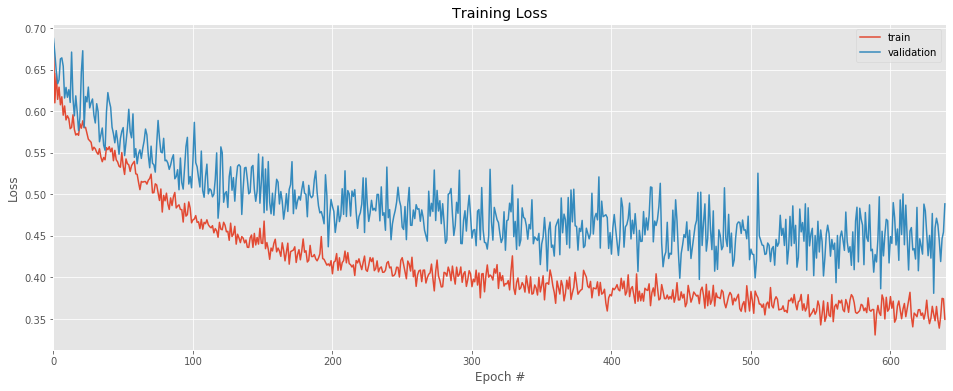

In [26]:
plt.style.use("ggplot")
plt.figure(figsize=(16, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.xlim(0, EPOCHS)
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.show()

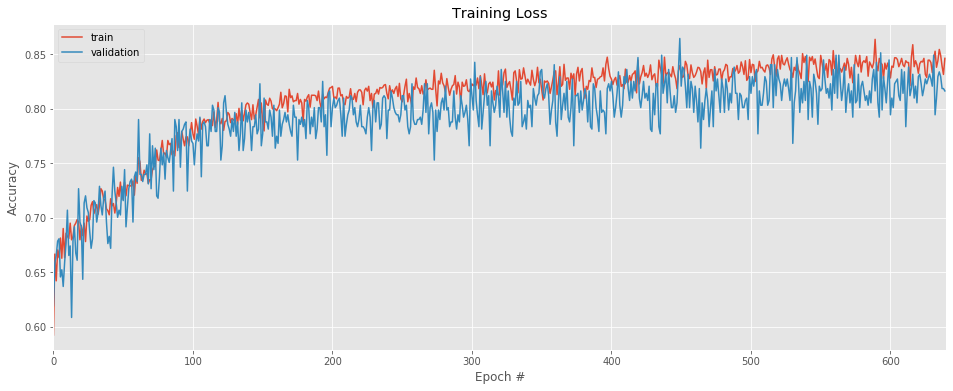

In [27]:
plt.style.use("ggplot")
plt.figure(figsize=(16, 6))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.xlim(0, EPOCHS)
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.show()